In [1]:
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_folder = ''
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder,
                                   download=True,
                                   train=False)

val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [2]:
import albumentations as A
import cv2

aug = A.Compose([
    A.Affine(
        translate_px={'x': (-10, 10)}, 
        scale=1.0,
        rotate=0,
        p=1.0,
        border_mode=cv2.BORDER_CONSTANT,
        cval=0
    )
])

/tmp/ipykernel_7291/795912265.py:5: UserWarning: Argument(s) 'cval' are not valid for transform Affine
  A.Affine(


In [3]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        x = np.array(x)  # Convertendo para numpy para aplicar a transformação
        if self.aug:
            # Aplicando a transformação
            x = self.aug(image=x)["image"]
        x = torch.tensor(x).float()  # Convertendo para tensor
        return x, y

    def __len__(self):
        return len(self.x)

    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))
        ims = torch.stack(ims)[:, None, :, :].to(device) / 255.  # Empilhando e normalizando as imagens
        classes = torch.tensor(classes).to(device)
        return ims, classes

        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims,classes

In [4]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.zero_grad()
    optimizer.step()
    return batch_loss.item()

In [8]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)  
    
    trn_dl = DataLoader(train, batch_size=64, 
                        collate_fn=train.collate_fn, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images),
                        collate_fn=val.collate_fn, shuffle=True)
    return trn_dl, val_dl

In [9]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
for epoch in range(5):
    print(f"Epoch {epoch}")  
    for ix, batch in enumerate(iter(trn_dl)):  
        x, y = batch  
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

Epoch 0


/tmp/ipykernel_7291/2118277950.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(x)  # Convertendo para numpy para aplicar a transformação


Epoch 1
Epoch 2
Epoch 3
Epoch 4


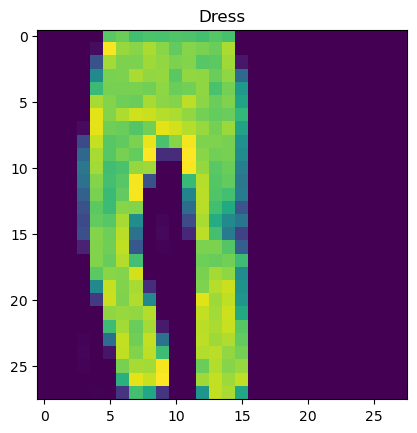

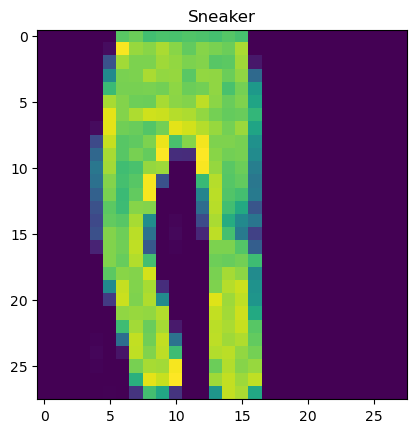

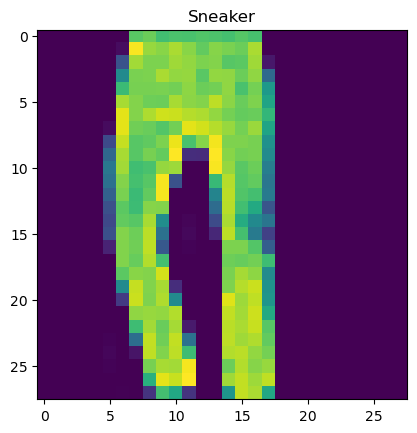

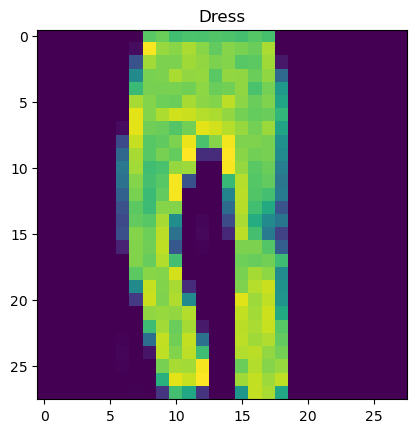

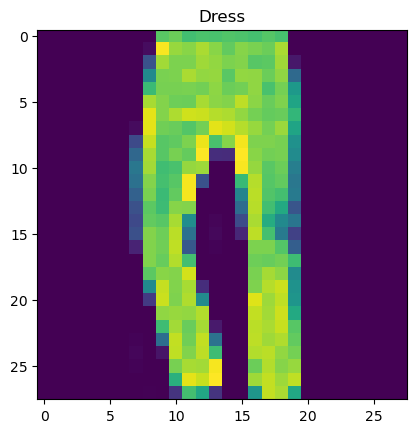

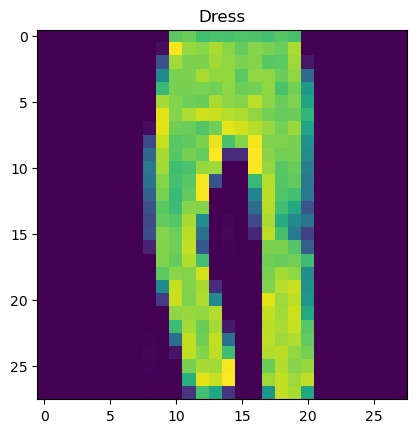

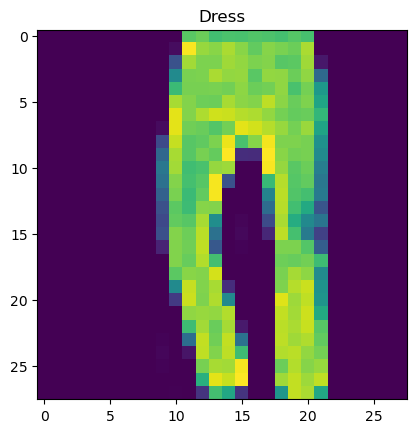

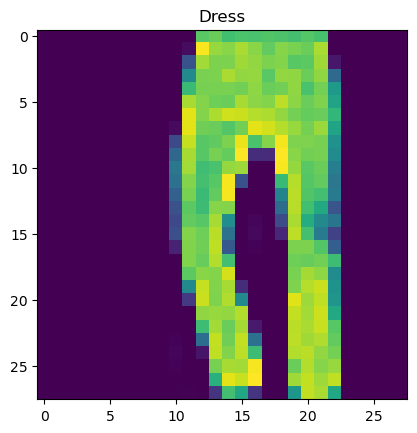

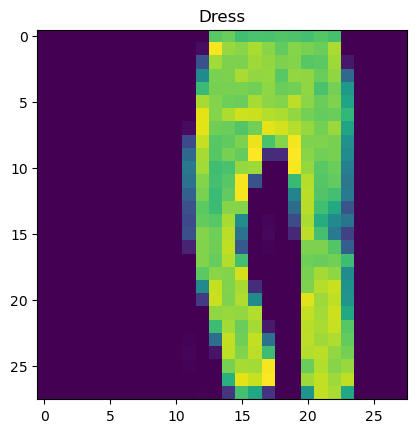

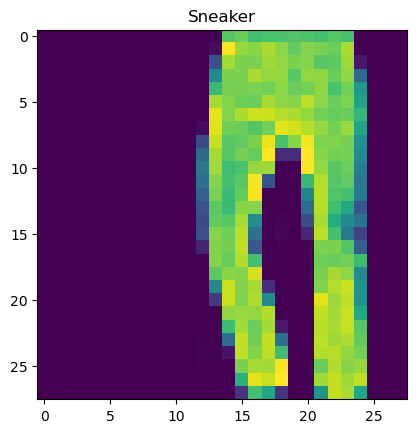

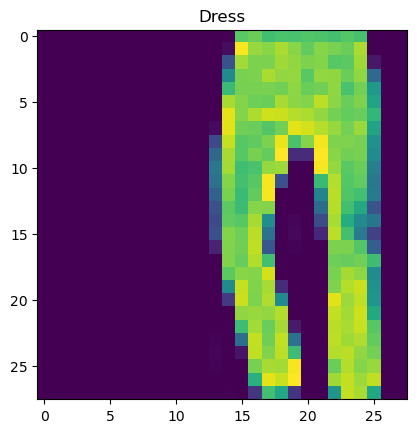

In [11]:
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255
    img = img.view(28,28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()
    